# Analysing trained models

In [2]:
import numpy as np
import random
from tqdm.notebook import tqdm
from copy import deepcopy
import time
import torch
import torch.nn as nn 
import torch.nn.functional as F
import pytorch_lightning as pl
pl.seed_everything(42)
from scipy.ndimage.filters import gaussian_filter1d

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.reset_orig()

Global seed set to 42


In [3]:
from graph_discovery import GraphDiscoveryMatrix
from utils import matrix_to_order
from causal_graphs.graph_generation import generate_categorical_graph, generate_chain, generate_random_graph
from causal_graphs.graph_definition import CausalDAG
from causal_graphs.graph_visualization import visualize_graph, visualize_local_graph
from causal_graphs.graph_utils import adj_matrix_to_edges
from causal_graphs.graph_real_world import load_graph_file

In [3]:
BASE_PATH = '../experiments/checkpoints/2021_03_29__11_49_33/'
BASE_PATH = '../experiments/checkpoints/2021_04_06__09_03_07/'
BASE_PATH = '../experiments/checkpoints/2021_04_18__10_07_35/'

In [4]:
NUM_VARS = 12
NUM_CATEGS = 10

graph = generate_categorical_graph(num_vars=NUM_VARS,
                                   min_categs=NUM_CATEGS,
                                   max_categs=NUM_CATEGS,
                                   edge_prob=0.2,
                                   connected=True,
                                   seed=43)

In [5]:
graph = CausalDAG.load_from_file(BASE_PATH + 'graph_1.pt')

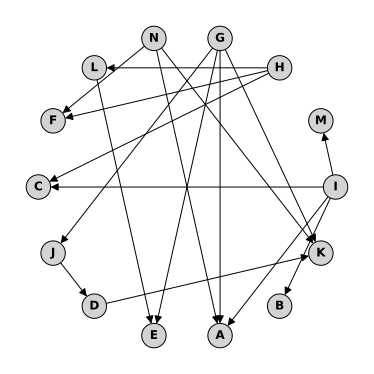

CausalDAG with 14 variables [I,M,H,G,N,L,F,C,J,D,E,A,B,K] and 17 edges:
I => M,C,A,B
H => L,F,C
G => J,E,A,K
N => F,A,K
L => E
J => D
D => K



In [6]:
visualize_graph(graph, show_plot=True, figsize=(5, 5), layout="circular")
print(graph)

In [7]:
discovery_module = GraphDiscoveryMatrix(graph=graph, model_iters=1000, lambda_sparse=0.001, batch_size=128, lr_permut=5e-3, 
                                        order_grads_opt='weight_expect_no_denom_weight_intervention', edge_grads_opt='weight_expect')
discovery_module.to(torch.device("cuda:0"))

MultivarMLP(
  (layers): ModuleList(
    (0): EmbedLayer(
      (input_mask): InputMask()
      (embedding): Embedding(2156, 64)
    )
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
    (2): MultivarLinear(c_in=64, c_out=64, extra_dims=[14])
    (3): LeakyReLU(negative_slope=0.1, inplace=True)
    (4): MultivarLinear(c_in=64, c_out=10, extra_dims=[14])
  )
)


In [15]:
state_dict = torch.load(BASE_PATH + 'state_dict_1_GraphDiscoveryMatrix.tar')
print(state_dict.keys())

dict_keys(['gamma', 'theta_matrix', 'model'])


In [9]:
discovery_module.load_state_dict(state_dict)

In [10]:
discovery_module.theta_matrix

Parameter containing:
tensor([[ 0.0000,  2.4503,  0.0919,  0.0339,  0.1570, -0.2401,  0.0298,  2.4991,
         -0.0818,  0.0496,  0.1362,  2.4879,  2.4685, -0.0896],
        [-2.4503,  0.0000,  0.1921,  0.0255, -0.0902, -0.0496,  0.2402, -0.2116,
          0.0764,  0.0665,  0.1884,  0.1045, -0.2239,  0.1510],
        [-0.0919, -0.1921,  0.0000, -0.1579,  0.2230,  2.4636,  2.4314,  2.4838,
          0.0309, -0.0249,  0.3790, -0.1055, -0.0994,  0.1633],
        [-0.0339, -0.0255,  0.1579,  0.0000, -0.0147, -0.0042,  0.2106,  0.1664,
          2.4287,  0.0127,  2.2852,  2.4973, -0.0552,  2.4927],
        [-0.1570,  0.0902, -0.2230,  0.0147,  0.0000,  0.1503,  2.4909, -0.0987,
         -0.0704, -0.1093,  0.1152,  2.4940, -0.0872,  2.4899],
        [ 0.2401,  0.0496, -2.4636,  0.0042, -0.1503,  0.0000,  0.3182, -0.0247,
          0.0845, -0.0641,  2.4448, -0.0070,  0.2102,  0.3466],
        [-0.0298, -0.2402, -2.4314, -0.2106, -2.4909, -0.3182,  0.0000, -0.4232,
         -0.1953, -0.1355, 

In [11]:
(discovery_module.theta_matrix > 1).long()

tensor([[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0')

In [28]:
graph.adj_matrix.astype(np.int32)

array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)

In [12]:
discovery_module.theta_matrix[10,5]

tensor(-2.4448, device='cuda:0', grad_fn=<SelectBackward>)

In [13]:
discovery_module.gamma[10,5]

tensor(3.4872, device='cuda:0', grad_fn=<SelectBackward>)

In [14]:
torch.round(torch.sigmoid(discovery_module.gamma) * 100)/ 100

tensor([[0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
         0.0000, 0.0000, 1.0000, 1.0000, 0.0100],
        [0.9800, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0200, 0.0000,
         0.0000, 0.0000, 0.0200, 0.6600, 0.0100],
        [0.0000, 0.0500, 0.0000, 0.0000, 0.0000, 1.0000, 1.0000, 1.0000, 0.0000,
         0.0000, 0.0000, 0.0100, 0.0000, 0.0100],
        [0.0100, 0.0600, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,
         0.0000, 1.0000, 1.0000, 0.0000, 1.0000],
        [0.0200, 0.0400, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 1.0000, 0.0000, 1.0000],
        [0.0100, 0.0600, 0.9800, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 1.0000, 0.0100, 0.0000, 0.0100],
        [0.0000, 0.0500, 0.9600, 0.0000, 0.9700, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0100, 0.0000, 0.0100],
        [0.9500, 0.0500, 0.9700, 0.0000, 0.0000, 0.0100, 0.0000, 0.0000, 0.0000,
  

## Checking model trained on real graph

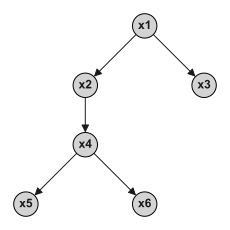

CausalDAG with 6 variables [x1,x2,x3,x4,x5,x6] and 5 edges:
x1 => x2,x3
x2 => x4
x4 => x5,x6



In [29]:
graph_real = load_graph_file('../causal_graphs/real_data/test_deterministic.bif')
visualize_graph(graph_real, show_plot=True, figsize=(3, 3))
print(graph_real)

In [28]:
discovery_module_real = GraphDiscoveryMatrix(graph=graph_real, model_iters=1000, lambda_sparse=0.001, batch_size=128, lr_permut=5e-3, 
                                             order_grads_opt='weight_expect_no_denom_weight_intervention', edge_grads_opt='weight_expect')
discovery_module_real.to(torch.device("cuda:0"))

In [31]:
state_dict = torch.load('../experiments/checkpoints/real_2021_03_29__17_24_12/state_dict_test_deterministic_GraphDiscoveryMatrix_seed42.tar')
discovery_module_real.load_state_dict(state_dict)

In [33]:
torch.round(torch.sigmoid(discovery_module_real.gamma) * 100) / 100

tensor([[0.0000, 0.9700, 0.9600, 0.7000, 0.2900, 0.2700],
        [0.8300, 0.0000, 0.7100, 0.9500, 0.6500, 0.6600],
        [0.8500, 0.7200, 0.0000, 0.2900, 0.1200, 0.1300],
        [0.5600, 0.6500, 0.2900, 0.0000, 0.9400, 0.9500],
        [0.2800, 0.3700, 0.1200, 0.5900, 0.0000, 0.6800],
        [0.2700, 0.3500, 0.1200, 0.6200, 0.6300, 0.0000]],
       grad_fn=<DivBackward0>)

In [37]:
graph.adj_matrix.astype(np.float32)

array([[0., 1., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]], dtype=float32)

## Sigmoid gradients

In [20]:
a = torch.linspace(-5, 5, 1000)
a.requires_grad_()
torch.sigmoid(a).sum().backward()

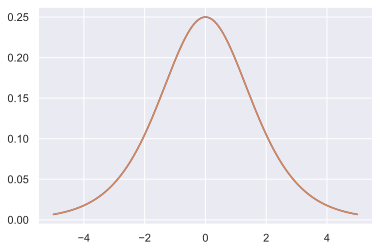

In [22]:
sns.set()
plt.plot(a.detach().numpy(), a.grad.detach().numpy())
plt.plot(a.detach().numpy(), (torch.sigmoid(a)*(1-torch.sigmoid(a))).detach().numpy())

## Analyse graphs

In [4]:
BASE_PATH = '../experiments/checkpoints/GD_1000_7598472_1/'
graph = CausalDAG.load_from_file(BASE_PATH + 'graph_1.pt')

In [17]:
graph.num_vars

1000

In [20]:
children = graph.adj_matrix.sum(axis=-1)
parents = graph.adj_matrix.sum(axis=0)

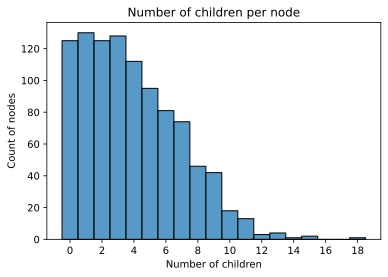

In [32]:
sns.histplot(children, bins=np.arange(np.max(children)+2)-0.5)
plt.title("Number of children per node")
plt.ylabel("Count of nodes")
plt.xlabel("Number of children")
_ = plt.xticks(np.arange(np.max(children)+1, step=2))

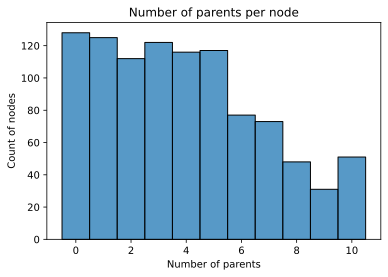

In [33]:
sns.histplot(parents, bins=np.arange(np.max(parents)+2)-0.5)
plt.title("Number of parents per node")
plt.ylabel("Count of nodes")
plt.xlabel("Number of parents")
_ = plt.xticks(np.arange(np.max(parents)+1, step=2))

In [24]:
np.max(parents)

10

In [31]:
empty_nodes = (parents == 0) * (children == 0)
print(empty_nodes.sum())

0


In [35]:
num_edges = graph.adj_matrix.sum()
print("Number of edges", num_edges)

Number of edges 3910


In [36]:
print(graph)

CausalDAG with 1000 variables [$X_{777}$,$X_{508}$,$X_{896}$,$X_{923}$,$X_{34}$,$X_{484}$,$X_{86}$,$X_{751}$,$X_{355}$,$X_{524}$,$X_{185}$,$X_{810}$,$X_{419}$,$X_{616}$,$X_{683}$,$X_{502}$,$X_{761}$,$X_{50}$,$X_{733}$,$X_{337}$,$X_{451}$,$X_{791}$,$X_{351}$,$X_{468}$,$X_{623}$,$X_{477}$,$X_{615}$,$X_{555}$,$X_{366}$,$X_{771}$,$X_{631}$,$X_{941}$,$X_{798}$,$X_{497}$,$X_{925}$,$X_{370}$,$X_{597}$,$X_{721}$,$X_{54}$,$X_{427}$,$X_{57}$,$X_{265}$,$X_{773}$,$X_{186}$,$X_{467}$,$X_{790}$,$X_{175}$,$X_{151}$,$X_{742}$,$X_{114}$,$X_{429}$,$X_{966}$,$X_{19}$,$X_{190}$,$X_{415}$,$X_{590}$,$X_{667}$,$X_{764}$,$X_{222}$,$X_{587}$,$X_{582}$,$X_{300}$,$X_{639}$,$X_{387}$,$X_{365}$,$X_{880}$,$X_{335}$,$X_{17}$,$X_{203}$,$X_{2}$,$X_{39}$,$X_{291}$,$X_{494}$,$X_{248}$,$X_{507}$,$X_{897}$,$X_{714}$,$X_{892}$,$X_{77}$,$X_{912}$,$X_{793}$,$X_{509}$,$X_{178}$,$X_{843}$,$X_{201}$,$X_{766}$,$X_{910}$,$X_{294}$,$X_{539}$,$X_{25}$,$X_{695}$,$X_{211}$,$X_{425}$,$X_{529}$,$X_{35}$,$X_{929}$,$X_{399}$,$X_{608}$,$X

## Logs

In [4]:
# BASE_PATH = '../experiments/checkpoints/2021_04_18__15_51_09/'
# BASE_PATH = '../experiments/checkpoints/2021_04_21__15_35_16/'
# BASE_PATH = '../experiments/checkpoints/2021_04_23__09_56_06/'
# BASE_PATH = '../experiments/checkpoints/2021_04_24__16_24_03/'
# BASE_PATH = '../experiments/checkpoints/array_job_200_7617862/experiment_2/'
BASE_PATH = '../experiments/checkpoints/2021_04_29__11_19_38/'
graph = CausalDAG.load_from_file(BASE_PATH + 'graph_1.pt')
sns.set()

In [5]:
s = graph.sample(batch_size=10000, as_array=True)
np.bincount(s[:,58])

array([ 277, 1105, 1560,  139,  380,  626, 1480, 1342,  960, 2131])

In [7]:
# torch.softmax(graph.variables[155].prob_dist.prob_func.net[2].bias, dim=-1)
# list(graph.variables[155].prob_dist.prob_func.net.named_parameters())
# for i in range(200):
#     if hasattr(graph.variables[i].prob_dist.prob_func, "net"):
#         graph.variables[i].prob_dist.prob_func.net[2].bias.data.fill_(0.0)

In [8]:
# visualize_graph(graph, show_plot=True, figsize=(30, 30), layout="graphviz")
# print(graph)
# print(graph.variables[33])
# print(graph.variables[166])

In [9]:
gamma = np.load(BASE_PATH + 'gamma_log_1_GraphDiscoveryMatrix.npz')["arr_0"].astype(np.float32)
gamma_grad = np.load(BASE_PATH + 'gamma_grad_log_1_GraphDiscoveryMatrix.npz')["arr_0"].astype(np.float32)
theta = np.load(BASE_PATH + 'theta_matrix_log_1_GraphDiscoveryMatrix.npz')['arr_0'].astype(np.float32)
theta_grad = np.load(BASE_PATH + 'theta_matrix_grad_log_1_GraphDiscoveryMatrix.npz')['arr_0'].astype(np.float32)

In [10]:
pred_matrix = (gamma[-1] > 0) * (theta[-1] > 0)

In [11]:
var_idxs = np.where(graph.adj_matrix != pred_matrix)

CausalVariable $X_{365}$
CausalVariable $X_{14}$


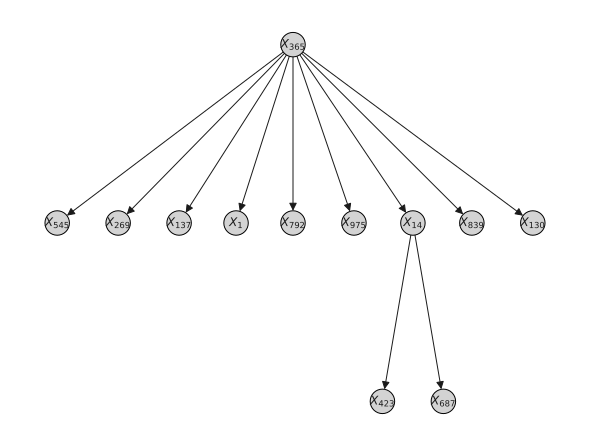

In [16]:
def vis_graph(node1, node2):
    print(graph.variables[node1])
    print(graph.variables[node2])
    visualize_local_graph(graph, nodes=[node1,node2], show_plot=True, figsize=(8, 6), layout="graphviz")
    
vis_graph(64, 272)

In [13]:
def plot_stats(X_IDX, Y_IDX):
    plt.figure(figsize=(5,3))
    plt.title("Gamma")
    plt.plot(gamma[:,X_IDX,Y_IDX])
    plt.show()
    plt.close()

    plt.figure(figsize=(5,3))
    plt.title("Gamma grad")
    if len(gamma_grad.shape) == 4:
        ggrad = gamma_grad[1::2,X_IDX,Y_IDX]
        plt.plot(ggrad[:,0], label="Mean", color="C0")
        std = np.sqrt(np.maximum(ggrad[:,1], 0.0))
        plt.fill_between(np.arange(ggrad.shape[0]), ggrad[:,0]-std,ggrad[:,0]+std, color="C0", alpha=0.2)
        plt.plot(ggrad[:,2], '--', label="Min", color="C2")
        plt.plot(ggrad[:,3], '--', label="Max", color="C3")
        plt.legend()
    else:
        plt.plot(gaussian_filter1d(gamma_grad[:,X_IDX,Y_IDX], sigma=1))
    plt.plot()
    plt.show()
    plt.close()

    plt.figure(figsize=(5,3))
    plt.title("Theta")
    plt.plot(theta[:,X_IDX,Y_IDX])
    plt.show()
    plt.close()

    plt.figure(figsize=(5,3))
    plt.title("Theta grad")
    if len(gamma_grad.shape) == 4:
        tgrad = theta_grad[::2,X_IDX,Y_IDX]
        plt.plot(tgrad[:,0], label="Mean", color="C0")
        std = np.sqrt(np.maximum(tgrad[:,1], 0.0))
        plt.fill_between(np.arange(tgrad.shape[0]), tgrad[:,0]-std,tgrad[:,0]+std, color="C0", alpha=0.2)
        plt.plot(tgrad[:,2], '--', label="Min", color="C2")
        plt.plot(tgrad[:,3], '--', label="Max", color="C3")
        plt.legend()
    else:
        plt.plot(gaussian_filter1d(theta_grad[:,X_IDX,Y_IDX], sigma=1))
    plt.show()
    plt.close()

X_IDX 64
Y_IDX 272


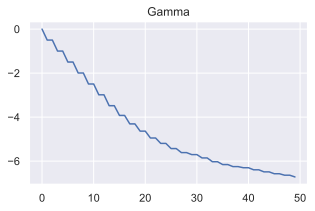

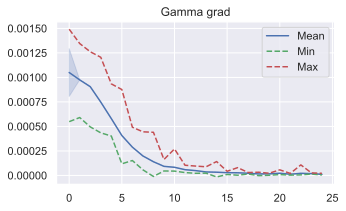

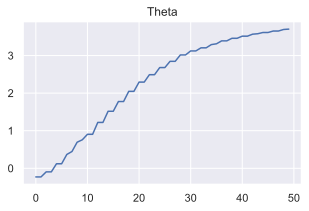

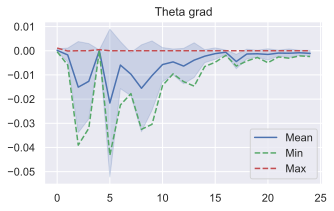

In [14]:
for i in range(var_idxs[0].shape[0]):
    X_IDX, Y_IDX = var_idxs[0][i], var_idxs[1][i]
    print("="*50)
    print("X_IDX", X_IDX)
    print("Y_IDX", Y_IDX)
    plot_stats(X_IDX, Y_IDX)

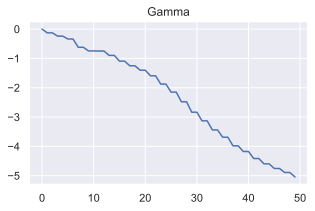

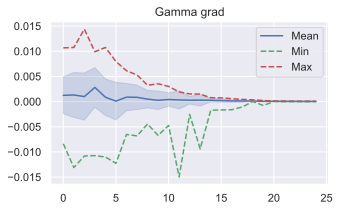

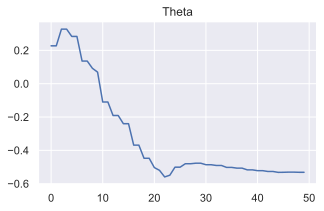

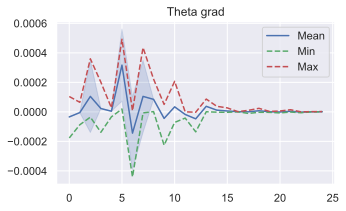

In [15]:
plot_stats(0, 82)

In [25]:
np.where(graph.adj_matrix)

(array([  0,   0,   0, ..., 978, 978, 984]),
 array([ 49,  82, 157, ..., 981, 990, 993]))

In [17]:
idx = np.argmax(gamma[-1] * (1 - graph.adj_matrix.astype(np.float32)) - 10 * graph.adj_matrix.astype(np.float32))
print(idx//graph.num_vars, idx%graph.num_vars)

121 29


In [19]:
idx = np.argmin(gamma[-1] * (graph.adj_matrix.astype(np.float32)) + 10 * (1 - graph.adj_matrix.astype(np.float32)))
print(idx//graph.num_vars, idx%graph.num_vars)

33 166


In [22]:
a = np.min(gamma[-1] * (graph.adj_matrix.astype(np.float32)) + 10 * (1 - graph.adj_matrix.astype(np.float32)))
np.where(gamma[-1] == a)

(array([33]), array([166]))

In [23]:
gamma[-1,33,166]

0.27943733